In [60]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import Optimizer
from torch import Tensor
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset, BatchSampler
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms as tf
from torchvision.models import vgg16, VGG, VGG16_Weights

import numpy as np
import pandas as pd

from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

import warnings
warnings.filterwarnings("ignore")

In [73]:
show_full_info = False

In [21]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Create Celebs Dataset

In [9]:
available_modes = ['train', 'val', 'test']
images_path = './celebA_train_500/celebA_imgs/'
class CelebDataset(Dataset):
    def __init__(self, mode: str = 'train'):
        if mode not in available_modes:
            raise ValueError(f'Unrecognized mode: {mode}')
        df = pd.read_csv('./celebA_train_500/celebA_train_split.txt', sep=' ', names=['Image', 'Mode'])
        self.image_annos = pd.read_csv('./celebA_train_500/celebA_anno.txt', sep=' ', names=['Image', 'Person'])
        self.train_images = df[df['Mode'] == 0]['Image'].to_numpy(dtype=str)
        self.val_images = df[df['Mode'] == 1]['Image'].to_numpy(dtype=str)
        self.test_images = df[df['Mode'] == 2]['Image'].to_numpy(dtype=str)
        self._mode = mode
    
    def __len__(self):
        return len(self.get_images_depend_on_mode())
    
    def __getitem__(self, index):
        image_name = self.get_images_depend_on_mode()[index]
        image_path = images_path + image_name
        image = np.array(Image.open(image_path))
        image = Image.fromarray(image[77:-41, 45:-50])
        transform = tf.Compose([tf.ToTensor()])
        transformed_image = transform(image)
        annotation: pd.DataFrame = self.image_annos
        person_id = annotation[annotation['Image'] == image_name]['Person'].values[0]
        return transformed_image, person_id
        
    def get_images_depend_on_mode(self) -> np.array:
        if self._mode == 'train':
            return self.train_images
        elif self._mode == 'val':
            return self.val_images
        elif self._mode == 'test':
            return self.test_images
        else:
            raise ValueError(f'Unrecognized mode: {self._mode}')
        
        

In [10]:
train_dataset = CelebDataset(mode='train')
val_dataset = CelebDataset(mode='val')
test_dataset = CelebDataset(mode='test')

# Let's look at cropped images from celeb dataset

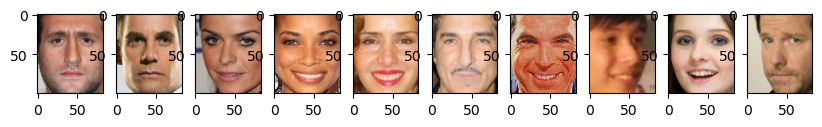

In [11]:
import random

nrows, ncols = 1,  10
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 7))
ax = ax.flatten()
to_pil = tf.ToPILImage()
for i in range(nrows * ncols):
    rand_index = random.randint(0, len(train_dataset) - 1)
    image_tensor = train_dataset.__getitem__(rand_index)[0]
    pil_image = to_pil(image_tensor)
    ax[i].imshow(pil_image)

In [ ]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=128)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=128)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=128)

## Train Loop Description

Let's describe a train function which we well user for all experiments with face recognition.

In [31]:
import datetime

def train(
        train_dataloader: DataLoader, 
        val_dataloader: DataLoader,
        criterion,
        optimizer: Optimizer,
        model: Module, 
        epochs: int = 20):
    
    timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
    summary_writer = SummaryWriter(f'runs/face_recognition_trainer_{timestamp}')
    
    for epoch in trange(epochs):
        for _, data in enumerate(train_dataloader):
            model.train(mode=True)
            
            images, labels = data
            
            predictions = model(images)
            loss: Tensor = criterion(predictions, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            model.eval()
            with torch.no_grad():
                for _, val_data in enumerate(val_dataloader):
                    val_images, val_labels = val_data
        
        summary_writer.flush()     
        
    model.eval()    
            


# VGG16 + Cross-Entropy Loss

Let's use pretrained VGG16 network. Here I change fully-connected layers and freeze convolutional layers to relearn the network to recognize faces. 

In [ ]:
model: VGG = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

# Freeze feature parameters in the "feature" section of the model, because we want to train only classifier
for param in model.features.parameters():
    param.requires_grad = False

# Let's assign a brand-new classifier to our model
model.classifier = nn.Sequential([])

In [ ]:
if show_full_info:
    from torchview import draw_graph
    model_graph = draw_graph(model, input_size=(1,3,224,224), expand_nested=True)
    model_graph.visual_graph

In [66]:

criterion = F.cross_entropy
optimizer = optim.Adam(model.parameters())

## Run Train Loop

In [23]:
train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataset,
    model=model,
    criterion=criterion,
    optimizer=optimizer
)

NameError: name 'train_dataloader' is not defined